# Indian Liver Patient (ILPD) Dataset
Data Spaces (01RLPOV), A.A. 2021/22  <br /> 
Politecnico di Torino - Corso di Laurea Magistrale in Ingegneria Informatica <br /> 
Elisa Cenedese - s255202 <br /> 


## Table of Contents

* [1. Introduction](#introduction)
    * [1.1 Dataset description](#dataset_descr)
    * [1.2 Check for missing values](#check_missing_values)
    * [1.3 Check for outliers](#check_outliers)
    * [1.4 Split dataset](#split_dataset)
* [2. Exploratory data analysis](#exploratory_data_analysis)
    * [2.1 Statistical quantitative description of features](#stat_features_descr)
    * [2.2 Box plots](#box_plots)
    * [2.3 Correlation analysis](#corr_analysis)
* [3. Preprocessing steps](#preprocessing_steps)
    * [3.1 Feature scaling](#scaling)
    * [3.2 Rebalancing](#rebalancing)
    * [3.3 Dimensionality reduction methods](#dim_reduction_methods)
       * [3.3.1 Principal component analysis](#pca)
       * [3.3.2 Empirical feature selection](#empirical_feature_selection)

In [ ]:
#Mount drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#Install
!pip install chart_studio
!pip install -U kaleido

In [ ]:
%matplotlib inline

#Imports
import pandas as pd
import os
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import itertools
import math
import pickle
from numpy import mean
from numpy import std
#plot libaries
import plotly
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import yaml
import pprint

from imblearn.over_sampling import SMOTENC
from matplotlib.colors import ListedColormap
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, f1_score
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn import tree, svm, linear_model, ensemble, neighbors 
from sklearn.svm import LinearSVC
from sklearn import preprocessing
from sklearn.base import clone
#from plotly.offline import init_notebook_mode
#init_notebook_mode(connected=True)
# online plotly
import chart_studio
chart_studio.tools.set_credentials_file(username='elisa_c', api_key='ixjDGQPn6k6yG1D96Wnr')
#chart_studio.tools.set_config_file(world_readable=False, sharing='secret')
import chart_studio.plotly as py
from scipy.cluster import hierarchy as hc

In [ ]:
#Paths
DATA_FILE_NAME = "indian_liver_patient_dataset.csv"

ROOT_DIRPATH = os.path.join(
    '/content',
    'drive',
    'MyDrive',
    'DataSpaces',
    'DataSpaces_project',
)

DATA_DIRPATH = os.path.join(
    ROOT_DIRPATH,
    'data',
)

MODELS_DIRPATH = os.path.join(
    ROOT_DIRPATH,
    'models',
)

data_file_path = os.path.join(DATA_DIRPATH, DATA_FILE_NAME)

if not os.path.exists(MODELS_DIRPATH):
    os.makedirs(MODELS_DIRPATH)

In [ ]:
def read_dataset(dirpath: str, file_type: str, sheet_name_=None):
  if file_type == "xlsx":
    dataset_df = pd.read_excel(dirpath, sheet_name= sheet_name_)
  elif file_type == "csv":
    with open(dirpath) as in_fp:
      dataset_df = pd.read_csv(in_fp, sep=',', header=0)
  else:
    raise Exception("Unrecognised dataset format")
  return dataset_df

In [ ]:
def show_dict(dict_: dict):
    pprint.pprint(dict_, width=1)

In [ ]:
def print_formatted_list(str_, list):
  print(str_ + ":")
  for value in list:
    print("  - " + str(value))
  print()

In [ ]:
def prepare_bar_plot(df, title, template_):
  colors = plotly.colors.DEFAULT_PLOTLY_COLORS
  data_series = df.value_counts() # return series
  data = [go.Bar(x=data_series.index, y=data_series.values, marker = dict(color = colors[:len(data_series.index)]))]
  layout = go.Layout(
      #paper_bgcolor='rgba(0,0,0,0)',
      #plot_bgcolor='rgba(0,0,0,0)',
      title=title,
      template = template_,
      autosize=False,
      width=400,
      height=400,
      yaxis=dict(
          title='#Patients',
      ),
  )
  fig = go.Figure(data=data, layout=layout)
  return fig, data_series

In [ ]:
def prepare_bar_plots(df1, df2, title, template_):

  colors = plotly.colors.DEFAULT_PLOTLY_COLORS
  data_series1 = df1.value_counts() # return series 
  data_series2 = df2.value_counts() # return series 

  fig = make_subplots(rows=1, cols=2,  subplot_titles=("Train", "Test"))

  fig.add_trace(
      go.Bar(x=data_series1.index, y=data_series1.values, marker = dict(color = colors[:len(data_series1.index)])),
      row=1, col=1
  )

  fig.add_trace(
      go.Bar(x=data_series2.index, y=data_series2.values, marker = dict(color = colors[:len(data_series2.index)])),
      row=1, col=2
  )

  fig.update_layout(title=title,
      template = template_,
      autosize=True,
      showlegend=False,
      width=400,
      height=400,
      yaxis=dict(
          title='#Patients',
      ))
  
  return fig, data_series1, data_series2

In [ ]:
def prepare_histogram_plot(X, features_names, class_names, config_dict, template_, per_feature=True):
  start_pos = 0
  data = []
  num_steps = len(features_names)

  for count_class, target in enumerate(class_names):
    trace_list = []
    for count, feature in enumerate(features_names):
      if count != start_pos:
        trace_list.append(go.Histogram(x=X[feature].loc[X[config_dict['TARGET_COLUMN_NAME']] == target], name = target, visible = False))
      else: 
        if per_feature and (count_class == 0 or count_class == 1):
            visibility_ =  True
        else:
            visibility_ =  'legendonly'
        trace_list.append(go.Histogram(x=X[feature].loc[X[config_dict['TARGET_COLUMN_NAME']] == target], name = target, visible = visibility_))
    data = data + trace_list

  trace_list_all_classes = []
  for count, feature in enumerate(features_names):
      if count != start_pos:
        trace_list_all_classes.append(go.Histogram(x=X[feature], name = 'all', visible = False))
      else: 
        if per_feature:
          visibility_ =  'legendonly'
        else:
           visibility_ = True
        trace_list_all_classes.append(go.Histogram(x=X[feature], name = 'all', visible = visibility_))

  data = data + trace_list_all_classes

  steps = []

  for i in range(num_steps):
      # Hide all traces
      step = dict(
          method = 'restyle',  
          args = ['visible', [False] * len(data)],
          label = features_names[i],
      )

      # Enable the traces we want to see
      for count, class_name in enumerate(class_names):
        #print(i+count*len(features_names))
        if per_feature and (count == 0 or count == 1):
          visibility_ =  True
        else:
          visibility_ =  'legendonly'
        step['args'][1][i+count*len(features_names)] = visibility_
     
      if per_feature:
        visibility_ = 'legendonly'
      else:
        visibility_ = True
      step['args'][1][i+(count+1)*len(features_names)] = visibility_
      
      # Add step to step list
      steps.append(step)

  sliders = [dict(
      active = start_pos, # from where to start the slider
      currentvalue = dict(
          prefix = "Feature: ", 
          xanchor= 'center',
      ),
      pad = {"t": 50},
      steps = steps,
      len=1,
  )]

  layout = dict(
      #paper_bgcolor='rgba(0,0,0,0)',
      #plot_bgcolor='rgba(0,0,0,0)',
      sliders=sliders,
      template = template_,  
      yaxis=dict(
          title='#Samples',
          automargin=True,
      ),
      #font=dict(
      #    color=font_color
      #)
  )

  return go.Figure(data=data, layout=layout)

In [ ]:
def prepare_box_plot(X, features_names, class_names, config_dict, title, template_):
  active_pos = 0
  data = []
  num_steps = len(features_names)

  for target in class_names:
    trace_list = []
    for count, feature in enumerate(features_names):
      if count != active_pos:
        trace_list.append(go.Box(y=X[feature].loc[X[config_dict['TARGET_COLUMN_NAME']] == target], name = target, visible = False))
      else:
         trace_list.append(go.Box(y=X[feature].loc[X[config_dict['TARGET_COLUMN_NAME']] == target], name = target, visible = True))
    data = data + trace_list

  steps = []

  for i in range(num_steps):
      # Hide all traces
      step = dict(
          method = 'restyle',  
          args = ['visible', [False] * len(data)],
          label = features_names[i],
      )
      # Enable the two traces we want to see
      for count, class_name in enumerate(class_names):
        #print(i+count*len(features_names))
        step['args'][1][i+count*len(features_names)] = True
        
      # Add step to step list
      steps.append(step)

  sliders = [dict(
      active = active_pos,
      currentvalue = dict(
          prefix = "Feature: ", 
          xanchor= 'center',
      ),
      pad = {"t": 50},
      steps = steps,
      len=1,
  )]

  layout = dict(
      #paper_bgcolor='rgba(0,0,0,0)',
      #plot_bgcolor='rgba(0,0,0,0)',
      sliders=sliders,
      title=title,
      template = template_,  
      yaxis=dict(
          title='Feature value',
          automargin=True,
      ),
      #font=dict(
      #    color=font_color
      #)
  )

  return go.Figure(data=data, layout=layout)

In [ ]:
def prepare_dendogram(X, title_, template_):
  colors = plotly.colors.DEFAULT_PLOTLY_COLORS
  feature_names = X.columns
  inverse_correlation = 1 - abs(X.corr())

  fig = ff.create_dendrogram(inverse_correlation.values, orientation='left', labels=feature_names, colorscale=colors, linkagefun=lambda x: hc.linkage(x, 'average'))
  
  fig['layout'].update(dict(
      title= title_,
      template= template_,
      width=800, 
      height=600,
      margin=go.layout.Margin(l=180, r=50),
      xaxis=dict(
          title='distance',
      ),
      yaxis=dict(
          title='features',
          automargin=True,
      ),
  ))
  return fig

In [ ]:
def prepare_heatmap(X, template_):
  corr = X.corr()
  trace = go.Heatmap(z=corr.values.tolist(), x=corr.columns, y=corr.columns)
  data=[trace]
  layout = go.Layout(
      title='Heatmap of pairwise correlation of the columns',
      autosize=False,
      template = template_,
      width=650,
      height=500,
      yaxis=go.layout.YAxis(automargin=True),
      xaxis=dict(tickangle=40),
      margin=go.layout.Margin(l=80, r=80, b=80, t=80)
  )

  return go.Figure(data=data, layout=layout)

In [ ]:
def prepare_pairplot(X, config_dict, combinations, features_names, title, template_):
  trace_list = []
  combinations_names = []
  start_pos = 0
  index_vals = X[config_dict['TARGET_COLUMN_NAME']].astype('category').cat.codes

  #combinations = list(itertools.combinations(range(len(features_list)), 2))
  num_steps = len(combinations)

  for couple in combinations:
    tuple_ = (features_names[couple[0]], features_names[couple[1]])
    combinations_names.append(str(tuple_))

  for count, couple in enumerate(combinations):
    #print(features_names[couple[0]], features_names[couple[1]])
    if count == start_pos:
      visibility_ = True
    else:
      visibility_ = False
 
    trace_list.append(go.Splom(dimensions=[dict(label=features_names[couple[0]],
                                                values=X[features_names[couple[0]]]),
                                          dict(label=features_names[couple[1]],
                                          values=X[features_names[couple[1]]])],
                              diagonal_visible=False, # remove plots on diagonal
                              text=X[config_dict['TARGET_COLUMN_NAME']],
                              marker=dict(color=index_vals,
                                          showscale=False, # colors encode categorical variables
                                          line_color='white', line_width=0.5),
                              visible = visibility_))

  steps = []
  
  for i in range(num_steps):
      # Hide all traces
      step = dict(
          method = 'restyle',  
          args = ['visible', [False] * len(trace_list)],
          label = combinations_names[i],
      )

      # Enable the traces we want to see
      step['args'][1][i] = True
        
      # Add step to step list
      steps.append(step)
  
  sliders = [dict(
      active = start_pos, # from where to start the slider
      currentvalue = dict(
            prefix = "Features couple: ", 
            xanchor= 'center',
      ),
      pad = {"t": 50},
      steps = steps,
      len=1,
    )]

  layout = dict(
        #paper_bgcolor='rgba(0,0,0,0)',
        #plot_bgcolor='rgba(0,0,0,0)',
        sliders=sliders,
        title=title,
        template = template_,  
        #font=dict(
        #    color=font_color
        #)
        width=600,
        height=600,
  )

  return go.Figure(data=trace_list, layout=layout)

In [ ]:
def prepare_PCA_explained_variance_plot(pca, template_):
  #explained_variance_ratio_ is the percentage of variance explained by each of the selected components.
  '''
  fig = plt.figure()
  plt.plot(np.cumsum(pca.explained_variance_ratio_), label="Cumulative variance")
  plt.plot(pca.explained_variance_ratio_, label="Component variance")
  plt.legend()
  plt.xlabel('Principal component')
  plt.ylabel('Explained variance ratio')
  '''
  cum_explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

  found_explained_variance_ratio = 0.0
  found_pc_id = 0
  for pc_id, value in enumerate(cum_explained_variance_ratio):
    if value >= 0.95:
      found_explained_variance_ratio = value
      found_pc_id = pc_id +1
      break

  trace_cum_var_exp = go.Scatter(
    x=list(range(1, len(pca.explained_variance_ratio_) + 1)), 
    y=pca.explained_variance_ratio_,
    name="Component explained variance",
  )
  trace_ind_var_exp = go.Scatter(
      x=list(range(1, len(cum_explained_variance_ratio) + 1)),
      y=cum_explained_variance_ratio,
      name="Cumulative explained variance",
    )
  data = [trace_cum_var_exp, trace_ind_var_exp]
  layout = go.Layout(
      template = template_,
      title='Individual and Cumulative Explained Variance',
      autosize=True,
      yaxis=dict(
          title='Explained variance ratio',
      ),
      xaxis=dict(
          title="Principal component",
          dtick=1,
      )
  )
  
  fig = go.Figure(data=data, layout=layout)

  fig.add_vline(x=found_pc_id, line_width=2, line_dash="dash", line_color="green")
  fig.add_hline(y=found_explained_variance_ratio, line_width=2, line_dash="dash", line_color="green")
      
  return fig

In [ ]:
def prepare_biplot(pca, X_pca_trasformed, y, features_names, template_):
  loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

  fig = px.scatter(X_pca_trasformed, x=0, y=1, color=y)

  for i, feature in enumerate(features_names):
      fig.add_shape(
          type='line',
          x0=0, y0=0,
          x1=loadings[i, 0],
          y1=loadings[i, 1]
      )
      fig.add_annotation(
          x=loadings[i, 0],
          y=loadings[i, 1],
          ax=0, ay=0,
          xanchor="center",
          yanchor="bottom",
          text=feature,
      )

  fig.update_layout( # customize font and legend orientation & position
    template = template_,
    width=700,
    height=700,
    legend_title_text='Class'
  )

  return fig

In [ ]:
def save(classifier, filepath):
  with open(filepath, "wb") as open_file:
    pickle.dump(classifier, open_file)

def load(filepath):
  with open(filepath, 'rb') as open_file:
      loaded_classifier = pickle.load(open_file)
  return loaded_classifier

def plot_PRC(clf_names, y_preds, y):
    fig = plt.figure(figsize=(6,6))
    ax = fig.gca()
    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([-0.1, 1.1])
    ax.grid(True)
    ax.set_aspect('equal')
    ax.legend(loc='lower right')
    ax.set_title("Precision-Recall Curves")
    for i, y_pr in enumerate(y_preds):
        metrics.PrecisionRecallDisplay.from_predictions(y, y_pr, name=clf_names[i], ax=ax)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    fig.show()

def plot_confusion_matrix(model, X, y, title='Confusion matrix'):
    fig = plt.figure()
    ax = fig.gca()
    ax.set_title(title)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    metrics.ConfusionMatrixDisplay.from_estimator(model, X, y, ax=ax)
    fig.show()
    #fig.savefig(filepath)

def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

def plot_2D_svm_decision_boundary(X_train, y_train, X_test, y_test, model, features_pair, title, apply_PCA=False):
   
    X_train_ = X_train[features_pair]
    X_test_ = X_test[features_pair]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_)
    X_test_scaled = scaler.transform(X_test_)

    if apply_PCA:
      pca = PCA()
      X_train_scaled = pca.fit_transform(X_train_scaled)
      X_test_scaled = pca.transform(X_test_scaled)

    sm = SMOTE(sampling_strategy='not majority', random_state=config_dict['GENERAL']['SEED'])
    X_train_augm, y_train_augm = sm.fit_resample(X_train_scaled, y_train)

    print("Fitting...")
    clf = model.fit(X_train_augm, y_train_augm)

    print("DONE")

    fig, ax = plt.subplots()
    # title for the plots
    #title = ('Decision surface of linear SVC ')
    # Set-up grid for plotting.
    X0, X1 = X_train_augm[:, 0], X_train_augm[:, 1]
    xx, yy = make_meshgrid(X0, X1)

    plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=y_train_augm, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_ylabel(features_pair[1])
    ax.set_xlabel(features_pair[0])
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)
    ax.legend()
    plt.show()

def plot_augmented_data(X_train, y_train, features_pair, scaler, balancer):
  fig, (ax1, ax2) = plt.subplots(1, 2)

  X_train_scaled = scaler.fit_transform(X_train)

  features_to_display_idx = [i for i, f in enumerate(scaler.get_feature_names_out()) if f in features_pair]

  X_train_augm, y_train_augm = balancer.fit_resample(X_train_scaled, y_train)

  X_train_scaled_ = X_train_scaled[:, features_to_display_idx]
  X_train_augm_ = X_train_augm[:, features_to_display_idx]

  ax1.scatter(X_train_augm_[:, 0], X_train_augm_[:, 1], c=y_train_augm.values.ravel(), alpha=0.8, edgecolor="k")
  title = f"Resampling with SMOTE"
  ax1.set_title(title)
  ax1.set_xlabel(features_pair[0])
  ax1.set_ylabel(features_pair[1])
  sns.despine(ax=ax1, offset=10)

  ax2.scatter(X_train_scaled_[:, 0], X_train_scaled_[:, 1], c=y_train.values.ravel(), alpha=0.8, edgecolor="k")
  title = f"Original data"
  ax2.set_title(title)
  ax2.set_xlabel(features_pair[0])
  ax2.set_ylabel(features_pair[1])
  sns.despine(ax=ax2, offset=10)

  fig.tight_layout()


def plot_logistic_curve(logistic_classifier, feature, X, y):
  
    feature_id = [i for i, f in enumerate(logistic_classifier.best_model.named_steps['scaler'].get_feature_names_out()) if f==feature][0]
    X_scaled = logistic_classifier.best_model.named_steps['scaler'].transform(X)
    
    trained_model = logistic_classifier.best_model.named_steps[logistic_classifier.name]
    plt.figure()
    m = trained_model.coef_[0,feature_id]
    b = trained_model.intercept_[0]
    x_v = X_scaled[:,feature_id]
    max_x_v = max(x_v)
    min_x_v = min(x_v)
    x_v = x_v * (max_x_v-min_x_v) + min_x_v
    rescale_factor = max_x_v-min_x_v
    #generate values for curve overlay
    lgs_curve = lambda x: 1/(1 + math.e**((int(max_x_v)+10)*(m*(x-rescale_factor)+b)))         
    x_values = np.linspace(int(min_x_v)-10, int(max_x_v)+10, int(max_x_v)+10)
    y_values = lgs_curve(x_values)
        
    print(x_v.shape)
    print(y.values.ravel().shape)

    plt.plot(x_values, y_values)
    plt.scatter(x_v, y.values.ravel(), c='r', s=2)
    plt.xlabel(feature)
    plt.ylabel("Probability of Liver disease")

def plot_decision_tree(decision_tree_classifier, feature_names, target_name, max_depth=None):

  trained_model = decision_tree_classifier.best_model.named_steps[decision_tree_classifier.name]
  plt.figure(figsize=(40,40))
  tree.plot_tree(trained_model, fontsize=10, feature_names=feature_names, 
                 class_names=[f"Liver disease=False", f"Liver disease=True"], 
                 label='all', filled=True, rounded=True, max_depth=max_depth)
  plt.show()

class Classifier:

  def __init__(self, name, model, class_general_conf, params_grid, class_balancer, feature_scaler):
    self.name = name
    self.model = model
    self.score_metric = class_general_conf['score_metric']
    self.cv_inner = class_general_conf['cv_inner']
    self.cv_outer = class_general_conf['cv_outer']
    self.seed = class_general_conf['seed']
    self.params_grid = params_grid
    self.class_balancer = class_balancer
    self.feature_scaler = feature_scaler
    self.pipeline = None
    self.apply_PCA = False
    self.num_components = 0

    self.ncv_global_mean_score = 0.0
    self.ncv_global_std_score = 0.0
    self.ncv_test_outer_results = []
    self.ncv_train_outer_results = []
    self.ncv_best_hyperparams = []
    self.ncv_inner_results = []
    self.ncv_trained = False

    self.trained = False
    self.best_model = None
    self.best_param = {}
    self.y_pred = []

  def cv(self, X_train, X_test, y_train, y_test, apply_PCA=False, num_components=None):
    if apply_PCA:
        self.pipeline = Pipeline([
                ('scaler', self.feature_scaler), 
                ('class_balancer', self.class_balancer),
                ('pca', PCA(n_components=num_components, random_state=self.seed)), 
                (self.name, self.model)
                ])
        self.apply_PCA = True
        self.num_components = num_components
    else:
        self.pipeline = Pipeline([
                ('scaler', self.feature_scaler), 
                ('class_balancer', self.class_balancer),
                (self.name, self.model)
                ])
    
    cv_inner = StratifiedKFold(n_splits=self.cv_inner, shuffle=True, random_state=self.seed)
    #scorer = make_scorer(self.score_metric, average = 'weighted')
    search = GridSearchCV(estimator=self.pipeline, param_grid=self.params_grid, cv=cv_inner,
                          scoring=self.score_metric, refit=True, verbose=4)

    # execute search
    search.fit(X_train, y_train.values.ravel())
    # get the best performing model fit on the whole training set 
    self.best_model = search.best_estimator_ 
    self.best_param = search.best_params_
    best_score = search.best_score_

    self.trained = True

    print('>> Predicting on test dataset...')
    self.y_pred = search.predict(X_test)

    self.print_results(X_train, X_test, y_train, y_test)
  
  def print_results(self, X_train, X_test, y_train, y_test):

    if self.trained == False:
      print("Train model before. Invoce cv()")
      return
  
    print('Best hyperparameters:')
    print(display(pd.DataFrame(self.best_param, index=[0])))
    print()

    print("Test classification report")
    print(classification_report(y_test, self.y_pred))

    plot_confusion_matrix(self.best_model, X_test, y_test,
                          f"Confusion matrix with {self.name}{' + PCA' if self.apply_PCA else ''}")
    

  def print_nested_cv_results(self):
    if self.ncv_trained == False:
      print("Nested cv not already performed. Invoke nested_cv() first.")
      return

    num_it = len(self.ncv_inner_results) 

    for i in range(0, num_it):

        print('\n--------------------------------------------\n')
        print(f"Inner CV (Hyperparameters and model selection): ")
        print(f"  F1-score = {self.ncv_inner_results[i]}")
        print(f"  Best hyperparams = {self.ncv_best_hyperparams[i]}")
        print(f"Outer CV (Quality of model selection assessment): ")
        print(f"  F1-score = {self.ncv_test_outer_results[i]}")
        print('\n--------------------------------------------\n')

    global_mean_score = mean(self.ncv_test_outer_results)
    global_std_score = std(self.ncv_test_outer_results)
    global_train_score = mean(self.ncv_train_outer_results)
    global_train_std = std(self.ncv_train_outer_results)

    print('\n--------------------------------------------\n')
    print(f"Mean training F1-score = {str(global_train_score)} ({str(global_train_std)})")
    print(f"Mean validation F1-score = {str(global_mean_score)} ({str(global_std_score)})")
    
    print("List of best hyperparameters to check stability: ")
    
    best_hyperparams_dict = {}
    for best_hyps in self.ncv_best_hyperparams:
      for k,v in best_hyps.items():
        if k not in best_hyperparams_dict:
            best_hyperparams_dict[k] = [v]
        else:
            best_hyperparams_dict[k].append(v)
    print(display(pd.DataFrame.from_dict(best_hyperparams_dict)))

        
  def nested_cv(self, X, y, apply_PCA=False, num_components=None):
    if self.ncv_trained == True:
      print("Nested cv already performed")
      self.print_nested_cv_results()
      return

    if apply_PCA:
        self.pipeline = Pipeline([
                ('scaler', self.feature_scaler), 
                ('class_balancer', self.class_balancer),
                ('pca', PCA(n_components=num_components, random_state=self.seed)), 
                (self.name, self.model)
                ])
        self.apply_PCA = True
        self.num_components = num_components
    else:
        self.pipeline = Pipeline([
                ('scaler', self.feature_scaler), 
                ('class_balancer', self.class_balancer),
                (self.name, self.model)
                ])
        
    ##apply nested cross validation
    # https://machinelearningmastery.com/nested-cross-validation-for-machine-learning-with-python/
    # the k-fold cross-validation procedure for model hyperparameter optimization is nested 
    # inside the k-fold cross-validation procedure for model selection. 
    # configure the outer cross-validation procedure to assess model performance
    cv_outer = StratifiedKFold(n_splits=self.cv_outer, shuffle=True, random_state=self.seed)

    for train_ix, test_ix in cv_outer.split(X, y):  # k outer folds, k = 10
        X_train, X_test = X.iloc[train_ix, :], X.iloc[test_ix, :]
        y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]
        
        print("Computing inner cross validation for grid search of best hyperparameters...")
        # configure the inner cross-validation procedure for grid search of best hyperparameters.  
        # selecting the best model (including parameters). 
        cv_inner = StratifiedKFold(n_splits=self.cv_inner, shuffle=True, random_state=self.seed)
        #scorer = make_scorer(self.score_metric, average = 'weighted')
        '''
        search = RandomizedSearchCV(estimator=self.pipeline, param_distributions=self.params_grid, 
                                    n_iter=20, cv=cv_inner, scoring=scorer, refit=True, verbose=2)
        '''
        search = GridSearchCV(estimator=self.pipeline, param_grid=self.params_grid, cv=cv_inner,
                              scoring=self.score_metric, refit=True, verbose=4)
        # refit = True --> configure the hyperparameter search to refit a final model
        # with the entire training dataset using the best hyperparameters found during the search.

        # execute search
        search.fit(X_train, y_train.values.ravel())
        # get the best performing model fit on the whole training set
        # This model can then be used to make predictions on the holdout data 
        # from the outer loop and estimate the performance of the model.
        best_model = search.best_estimator_ 
        best_param = search.best_params_
        best_score = search.best_score_
        
        # evaluate the performance of the model on the hold out data.
        #  you are not assessing just the quality of the model, but the quality of the procedure for model selection
        y_test_pred = search.predict(X_test)
        test_score = f1_score(y_test, y_test_pred)
        y_train_pred = search.predict(X_train)
        train_score = f1_score(y_train, y_train_pred)

        self.ncv_inner_results.append(best_score)
        self.ncv_test_outer_results.append(test_score)
        self.ncv_train_outer_results.append(train_score)
        self.ncv_best_hyperparams.append(best_param)
    
        print('\n--------------------------------------------\n')
        print(f"Inner CV (Hyperparameters and model selection): ")
        print(f"  F1-score = {best_score}")
        print(f"  Best hyperparams = {best_param}")
        print(f"Outer CV (Quality of model selection assessment): ")
        print(f"  F1-score = {test_score}")
        print('\n--------------------------------------------\n')

    self.ncv_global_mean_score = mean(self.ncv_test_outer_results)
    self.ncv_global_std_score = std(self.ncv_test_outer_results)
    global_train_score = mean(self.ncv_train_outer_results)
    global_train_std = std(self.ncv_train_outer_results)

    print('\n--------------------------------------------\n')
    print(f"Mean training F1-score = {str(global_train_score)} ({str(global_train_std)})")
    print(f"Mean validation F1-score = {str(self.ncv_global_mean_score)} ({str(self.ncv_global_std_score)})")
    
    print("List of best hyperparameters to check stability: ")
    
    best_hyperparams_dict = {}
    for best_hyps in self.ncv_best_hyperparams:
      for k,v in best_hyps.items():
        if k not in best_hyperparams_dict:
            best_hyperparams_dict[k] = [v]
        else:
            best_hyperparams_dict[k].append(v)
    print(display(pd.DataFrame.from_dict(best_hyperparams_dict)))

    self.ncv_trained = True

    return self.ncv_global_mean_score, self.ncv_global_std_score

In [ ]:
config_dict = {}

config_dict['GENERAL'] = {
    'SEED': 42,
    'TARGET_COLUMN_NAME': "CLASS",
    'NUMERIC_FEATURES': ['Age','TB','DB','AAP','SGPT','SGOT','TP','ALB','AGR'],
    'BOOLEAN_FEATURES': ['Gender'],
    'SHOW_METHOD': 1, # 0 for colab, 1 for plotly, 2 for static png figures
    'PERFORM_NCV': True
}

if config_dict['GENERAL']['SHOW_METHOD'] > 0:
  template_ =  'plotly_white'
else:
  template_ = 'plotly_dark'

show_dict(config_dict)

## 1. Introduction<a class="anchor" id="introduction"></a>
The dataset used in this project was collected from north east of Andhra Pradesh, India and contains 583 *Liver Patient* records.
The data source is available on the UCI ML Repository at the following link:
https://archive.ics.uci.edu/ml/datasets/ILPD+%28Indian+Liver+Patient+Dataset%29# <br/>

Patients with liver disease are continuously increasing particularly due to the large consumption of alcohol, intake of dangerous gases, use of drugs and use of contaminated food.
Automatic classification algorithms my help doctors in speed up the diagnosis and increase patients survival rate.
The aim of the project is therefore to analyze the presented dataset and compare some ML classification methods capable of distinguishing between *Liver* and *No Liver* patients.

The report is divided into 5 main chapters of which the first 2 are dedicated to an exploratory analysis of the data, the two centrals (3 - 4) concern the classification phase and the last one is dedicated to the conclusions.

###1.1 Dataset description<a class="anchor" id="dataset_descr"></a>
The dataset contains 416 instances with liver disease (71.36%) and 167 instances without the disease (28.64%); this means that we are dealing with a binary classification task, where the two categorical class labels are respectively *Liver Patient* and *No Liver Patient*.

Attributes description:

| Attribute Name  | Description  | Data Type  | Attribute Type | 
|---|---|---|---|
| Age  |  Age of the patient (Any patient whose age exceeded 89 is listed as being of age "90") | Integer | Numeric |
| Gender | Gender of the patient  | String -> Integer| Binary |
| TB | Total Bilirubin | Real number |  Numeric |
| DB | Direct Bilirubin  | Real number | Numeric  |
| AAP | Alkphos Alkaline Phosphotase   | Integer  |  Numeric |
| SGPT  | Sgpt Alamine Aminotransferase  |  Integer | Numeric | 
| SGOT |  Sgot Aspartate Aminotransferase |  Integer | Numeric | 
| TP |  Total Proteins | Real number | Numeric  |
| ALB | Albumin  | Real number  | Numeric|
| AGR | A/G Ratio Albumin and Globulin Ratio  | Real number |Numeric |

As we can see from the table above, the features report clinical informations of the patients. They are 10 in total, 9 of which are numeric and 1 is binary.

Before performing the exploratory data analysis and the classification, the following preprocessing steps are applied to the data:
1. Change class label values for *No Liver Patient* from 2 to 0, to follow the more common naming convention for binary classification (0 for negative class and 1 for positive class).
2. Use the Label Encoding technique to encode the **Gender** categorical feature  ("Female"/"Male") respectively with the integer values 0 and 1, to convert them into a machine-readable form.





In [ ]:
dataset_df = read_dataset(data_file_path, file_type= "csv")
dataset_df.loc[dataset_df['CLASS'] == 2, 'CLASS'] = 0

le = preprocessing.LabelEncoder()
dataset_df['Gender'] = le.fit_transform(dataset_df['Gender'])
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label encoding for Gender feature:")
print(f"{le_name_mapping}\n")

print("Some Dataset records:")
display(dataset_df.head())

X = dataset_df.drop(columns=[config_dict['GENERAL']['TARGET_COLUMN_NAME']])
y = dataset_df[config_dict['GENERAL']['TARGET_COLUMN_NAME']] # dataframe containing class column

features_names = X.columns.values
#print_formatted_list("Feature names", features_names)
class_names = list(set(y))
#print_formatted_list("Class names", class_names)

fig, data_series = prepare_bar_plot(y, title = "Distribution of samples per class", template_=template_)
print(f'\nNumber of samples = {dataset_df.shape[0]} | Number of features = {len(features_names)}\n')
for value in zip(data_series.values, data_series.index):
    if(value[1] == 1):
      class_name = "Liver Patient"
    else:
      class_name = "No Liver Patient"
    print("%s (class label = %s): %d instances (%.2f%%)" % (class_name, value[1], value[0], (value[0]/y.shape[0])*100))
print()

'''
if config_dict['GENERAL']['SHOW_METHOD'] == 0:
  fig.show()
elif config_dict['GENERAL']['SHOW_METHOD'] == 1:
  py.iplot(fig, filename = 'bar_plot')
elif config_dict['GENERAL']['SHOW_METHOD'] == 2:
  fig.show(renderer='svg')
'''
py.iplot(fig, filename = 'bar_plot_per_class')

Label encoding for Gender feature:
{'Female': 0, 'Male': 1}

Some Dataset records:


,Age,Gender,TB,DB,AAP,SGPT,SGOT,TP,ALB,AGR,CLASS
0,65,0,0.7,0.1,187,16,18,6.8,3.3,0.90,1
1,62,1,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,1,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,1,1.0,0.4,182,14,20,6.8,3.4,1.00,1
4,72,1,3.9,2.0,195,27,59,7.3,2.4,0.40,1



Number of samples = 583 | Number of features = 10

Liver Patient (class label = 1): 416 instances (71.36%)
No Liver Patient (class label = 0): 167 instances (28.64%)



From the bar char above we can see that the distribution of the samples among the two classes is unbalanced (71.36% of records are *Liver Patients*). We will see in chapter [3.2](#Rebalancing) how to deal with an unbalanced dataset.

###1.2 Check for missing values<a class="anchor" id="check_missing_values"></a>
We can observe below that there are 4 missing values for the attribute **AGR** in the dataset. The min value is close for the two classes, while the max value is a little bit larger for the positive class. The mean value shows than on average there are no substantial differences between the two classes for that attribute.

In [ ]:
# check for null values in the dataset
print("Missing values per feature:")
print(X.isna().sum())
print()
aggregate_df = dataset_df.groupby('CLASS', as_index=False)['AGR'].min().rename(columns={'AGR': 'min(AGR)'})
aggregate_df['max(AGR)'] = dataset_df.groupby('CLASS', as_index=False)['AGR'].max().rename(columns={'AGR': 'max(AGR)'})['max(AGR)']
aggregate_df['mean(AGR)'] = dataset_df.groupby('CLASS', as_index=False)['AGR'].mean().rename(columns={'AGR': 'mean(AGR)'})['mean(AGR)']
display(aggregate_df)

Missing values per feature:
Age       0
Gender    0
TB        0
DB        0
AAP       0
SGPT      0
SGOT      0
TP        0
ALB       0
AGR       4
dtype: int64



,CLASS,min(AGR),max(AGR),mean(AGR)
0,0,0.37,1.9,1.029576
1,1,0.30,2.8,0.914179


The patients with missing values are only 4. The choice is to put as value for the **AGR** attribute the mean computed per class to which the patient belongs.

In [ ]:
dataset_df['AGR'].fillna(dataset_df.groupby('CLASS')['AGR'].transform('mean').round(2), inplace = True)
X = dataset_df.drop(columns=[config_dict['GENERAL']['TARGET_COLUMN_NAME']])
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583 entries, 0 to 582
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Age     583 non-null    int64  
 1   Gender  583 non-null    int64  
 2   TB      583 non-null    float64
 3   DB      583 non-null    float64
 4   AAP     583 non-null    int64  
 5   SGPT    583 non-null    int64  
 6   SGOT    583 non-null    int64  
 7   TP      583 non-null    float64
 8   ALB     583 non-null    float64
 9   AGR     583 non-null    float64
dtypes: float64(5), int64(5)
memory usage: 45.7 KB


###1.3 Checking for outliers<a class="anchor" id="check_outliers"></a>

The interactive histogram below shows the distribution of each feature for *Liver Patients* and *No Liver Patients*.

Concerning the **Gender** we can see that the Female patients are less then the Male patients and this distribution is quite preserved on both the 2 classes (*Liver* / *No Liver*).

For both class labels the **Age** values ​​range from children to the elderly, although the largest number of patients is concentrated in the range between 30 and 60 and the mean Age is around 40.

The five features **TB**, **DB**, **AAP**, **SGPT**, **SGOT** have some data more shifted to the right (larger values) for patients with liver disease, infact the median and especially the mean, are larger with respect to those of the group without the disease. In addition, is possible to observe that some diseased patients have very high values for those features. We do not consider these ​​as outliers as they are possible values ​​in patients with advanced disease and can help us to discriminate between the two classes.
It is also possible to observe that many patients labeled as diseased have still "normal" values.


In [ ]:
fig = prepare_histogram_plot(dataset_df, features_names, class_names, config_dict['GENERAL'], template_)
'''
if config_dict['GENERAL']['SHOW_METHOD'] == 0:
  fig.show()
elif config_dict['GENERAL']['SHOW_METHOD'] == 1:
  py.iplot(fig, filename = 'bar_plot')
elif config_dict['GENERAL']['SHOW_METHOD'] == 2:
  fig.show(renderer='svg')
'''
py.iplot(fig, filename = 'bar_plot_per_feature')

In [ ]:
#grouped_df = dataset_df.groupby(['CLASS','Gender']).size().reset_index(name='Counts')
#display(grouped_df)
no_liver_group_patients = dataset_df.loc[dataset_df["CLASS"] == 0]
no_liver_group_patients = no_liver_group_patients["Gender"].value_counts(normalize=True).round(4) * 100
no_liver_group_patients = no_liver_group_patients.to_frame().reset_index()
no_liver_group_patients.columns = ["Gender", "%"]
print("No liver Patients:")
display(no_liver_group_patients)
print()
liver_group_patients = dataset_df.loc[dataset_df["CLASS"] == 1]
liver_group_patients = liver_group_patients["Gender"].value_counts(normalize=True).round(4) * 100
liver_group_patients = liver_group_patients.to_frame().reset_index()
liver_group_patients.columns = ["Gender", "%"]
print("Liver Patients:")
display(liver_group_patients)

 | Class|Gender |  %| 
 |---|---|---|
 |No Liver Patient| 1  | 70.06  | 
 |No  Liver PAtient | 0 | 29.94  | 
 |Liver Patient| 1  | 77.88  | 
 |Liver PAtient | 0 | 22.12  | 


###1.5 Split dataset<a class="anchor" id="split_dataset"></a>
The data is splitted into 2 separated datasets with stratification, in order to mantain the distribution of samples among the 2 classes. The training dataset $X_{train}$ is used to train the classification model, while the test dataset $X_{test}$ is used to test the performance of the trained model on "new" data. This prevent any leakage of information from the test dataset into the preprocessing and training phase and allows to provide an unbiased evaluation of the final model.
The sizes of the obtained datasets are reported below:

|   | Train  |  Test | Tot|  
|---|---|---|---|
| %  | 80  | 20  | 100|
|  Number of samples | 466  | 117  | 583| 
  

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=config_dict['GENERAL']['SEED'], stratify=y, shuffle=True)

The bar chart shows the distribution of the samples among the two classes for the training and test datasets. From the chart is possible to notice that the distribution of the original data is preserved after the splitting.

In [ ]:
fig, data_series_train, data_series_test = prepare_bar_plots(y_train, 
                                                             y_test, 
                                                             "Distribution of patients per classs", 
                                                             template_)

py.iplot(fig, filename = 'bar_plot_train_test')

In [ ]:
print(f'Train dataset length: {X_train.shape[0]}\n')
for value in zip(data_series_train.values, data_series_train.index):
    print("%s: %d instances (%.2f%%)" % (value[1], value[0], (value[0]/y_train.shape[0])*100))
print()

print(f'Test dataset length: {X_test.shape[0]}\n')
for value in zip(data_series_test.values, data_series_test.index):
    print("%s: %d instances (%.2f%%)" % (value[1], value[0], (value[0]/y_test.shape[0])*100))
print()

Train dataset length: 466

1: 333 instances (71.46%)
0: 133 instances (28.54%)

Test dataset length: 117

1: 83 instances (70.94%)
0: 34 instances (29.06%)



##2. Exploratory data analysis<a class="anchor" id="exploratory_data_analysis"></a>

The chapter aims to investigate the correlation among the features and their ranges of values, in order to decide to make or not some preprocessing step. The analysis is done by considering only the training data to prevent any data leakage from the test dataset in the decision making.

###2.1 Statistical quantitative description of features<a class="anchor" id="stat_features_descr"></a>

The table below shows a descriptive statistic for each feature of the training dataset, regardless of class label. Only numeric features are included in this quantitative analysis.

For numeric data, the result’s index includes:
- count: number of samples
- mean: the mean of the attribute among all samples
- std: the standard deviation of the attribute
- min: the minimum value of the attribute
- 25%: the lower percentile
- 50%: the median
- 75%: the upper percentile
- max: the maximum value of the attribute

We can observe that the range of values of the features vary greatly, for this reason is important to standardize the data before applying ML methods, to make sure that all the features equally contribute during training process. We will see this process in chapter [3.1](#Feature scaling). 

In [ ]:
display(X_train[config_dict['GENERAL']['NUMERIC_FEATURES']].describe())

,Age,TB,DB,AAP,SGPT,SGOT,TP,ALB,AGR
count,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000
mean,44.519313,2.976180,1.372961,294.019313,83.150215,103.881974,6.483906,3.153219,0.951288
std,16.000694,4.959016,2.558393,252.866027,193.080002,223.780425,1.078439,0.789283,0.315742
min,4.000000,0.400000,0.100000,75.000000,10.000000,10.000000,3.000000,1.000000,0.300000
25%,33.000000,0.800000,0.200000,176.250000,23.000000,25.000000,5.700000,2.600000,0.750000
50%,45.000000,1.000000,0.300000,208.500000,35.000000,41.000000,6.550000,3.100000,0.955000
75%,57.000000,2.600000,1.275000,298.000000,60.000000,83.750000,7.200000,3.800000,1.100000
max,90.000000,30.500000,17.100000,2110.000000,2000.000000,2946.000000,9.600000,5.500000,2.800000


Below is reported the quantitative description, per class. In the next section the box plots are shown to better visualize the different statistics of the features with respect to the class label.

In [ ]:
X_train_class = X_train.copy()
X_train_class[config_dict['GENERAL']['TARGET_COLUMN_NAME']] = y_train

liver_patients = X_train_class.loc[X_train_class[config_dict['GENERAL']['TARGET_COLUMN_NAME']] == 1].drop(columns=[config_dict['GENERAL']['TARGET_COLUMN_NAME']])
no_liver_patients = X_train_class.loc[X_train_class[config_dict['GENERAL']['TARGET_COLUMN_NAME']] == 0].drop(columns=[config_dict['GENERAL']['TARGET_COLUMN_NAME']])
print("Quantitative description (class 1):")
display(liver_patients[config_dict['GENERAL']['NUMERIC_FEATURES']].describe()) # per class
print()
print("Quantitative description (class 0):")
display(no_liver_patients[config_dict['GENERAL']['NUMERIC_FEATURES']].describe()) # per class

Quantitative description (class 1):


,Age,TB,DB,AAP,SGPT,SGOT,TP,ALB,AGR
count,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000
mean,46.069069,3.687988,1.750150,321.027027,102.405405,129.072072,6.452553,3.080480,0.924715
std,15.272565,5.672341,2.921767,278.417455,224.982732,259.551387,1.070765,0.768983,0.323926
min,7.000000,0.400000,0.100000,75.000000,12.000000,11.000000,3.000000,1.000000,0.300000
25%,34.000000,0.800000,0.200000,185.000000,25.000000,28.000000,5.700000,2.600000,0.700000
50%,46.000000,1.300000,0.500000,228.000000,40.000000,50.000000,6.600000,3.000000,0.900000
75%,58.000000,3.300000,1.600000,316.000000,74.000000,104.000000,7.100000,3.700000,1.100000
max,90.000000,30.500000,17.100000,2110.000000,2000.000000,2946.000000,9.600000,5.500000,2.800000



Quantitative description (class 0):


,Age,TB,DB,AAP,SGPT,SGOT,TP,ALB,AGR
count,133.000000,133.000000,133.000000,133.000000,133.000000,133.000000,133.000000,133.000000,133.000000
mean,40.639098,1.193985,0.428571,226.398496,34.939850,40.812030,6.562406,3.335338,1.017820
std,17.146578,1.107123,0.573476,154.385828,27.197304,36.922349,1.097559,0.812702,0.284675
min,4.000000,0.500000,0.100000,90.000000,10.000000,10.000000,3.700000,1.400000,0.370000
25%,27.000000,0.700000,0.200000,162.000000,20.000000,21.000000,5.900000,2.900000,0.900000
50%,38.000000,0.800000,0.200000,188.000000,28.000000,30.000000,6.500000,3.300000,1.000000
75%,55.000000,1.100000,0.400000,215.000000,37.000000,43.000000,7.400000,4.000000,1.200000
max,85.000000,7.300000,3.600000,1580.000000,181.000000,285.000000,9.200000,5.000000,1.850000


###2.2 Box plots<a class="anchor" id="box_plots"></a>

One whisker box is plotted per numeric feature to visualize whether each feature presents different characteristics depending on the target class.
Before MinMax Scaler is applied to scale each feature to have the same range [0, 1]. 

A box plot visualizes the following main statistics:
- median
- the first quartile (Q1) and the third quartile (Q3) building the interquartile range (IQR)
- the lower fence (Q1 - 1.5 IQR) and the upper fence (Q3 + 1.5 IQR)
- the maximum and the minimum value

Concerning the features **TB**, **DB**, **AAP**, **SGPT**, **SGOT**, the median and especially the mean are higher in the *Liver Patient* class. In addition, is possible to observe how, for class *Liver Patient*, there is a good number of samples whose values are very different from the median and tend to have much greater values.
Those set of features could be good candidate to discriminate among classes.

As regards the features **TP**, **ALB**, **AGR**, median and mean do not change a lot among the 2 classes. The only observation is that *Liver Patients* tend to have some slighly lower values, beshid  some "outliers".





In [ ]:
X_train_class_scaled = X_train_class.copy()
X_train_class_scaled[features_names] = MinMaxScaler().fit_transform(X_train_class_scaled[features_names])
fig = prepare_box_plot(X_train_class_scaled, config_dict['GENERAL']['NUMERIC_FEATURES'], class_names, config_dict['GENERAL'], "Box plots per class", template_)

'''
if config_dict['GENERAL']['SHOW_METHOD'] == 0:
  fig.show()
elif config_dict['GENERAL']['SHOW_METHOD'] == 1:
  py.iplot(fig, filename = 'bo_plot_scaled')
elif config_dict['GENERAL']['SHOW_METHOD'] == 2:
  fig.show(renderer='svg')
'''
py.iplot(fig, filename = 'box_plot_scaled')

###2.3 Correlation analysis<a class="anchor" id="corr_analysis"></a>
To understand if there is some correlation among features the correlation matrix is shown as heatmap plot, in which high positive correlations are coloured more to the yellow and lower ones more to the purple. Negative correlations tend to be coloured in blue.

The correlation matrix C is simply a square matrix which display in each entry the correlation coefficient between two variable $X_i$ and $X_j$.
The correlation coefficient is the Pearson's correlation coefficient that is obtained in the following way:

  $c_{ij} = \dfrac{Cov(X_i,X_j)}{\sigma_{X_i} \sigma_{X_j}}$

where the numerator is the covariance of the two variables and the denominator is the product of their standard deviations.

From the C matrix is possible to see that the feature pairs with higher correlation are the following:

| Feature pair| Pearson's correlation coefficient|
|---|---|
| (TB, DB) | 0.98 |
| (SGPT, SGOT) | 0.88 | 
| (TP, ALB) | 0.80 |
| (AGR, ALB) | 0.68 | 

while there is no feature pairs with high negative correlation.

**TB** and **DB**, as shown in the matrix, are highly correlated, in fact Total Bilirubin is nothing more than the sum of Direct and Indirect Bilirubin. Direct Bilirubin in particular can indicate liver problems if present in high values. Concerning **SGOT** and **SGPT**, both are transaminases and elevated levels may be an indication of liver cell injury or damage. Albumina (**ALB**) is known to be about 60% of total proteins (**TP**), while **AGR** is computed as the ratio between Albumina and Globulina. This can help to explain the positive correlation between **TP** and **ALB** and between **ALB** and **ABR**. 


In [ ]:
fig = prepare_heatmap(X_train, template_)

'''
if config_dict['GENERAL']['SHOW_METHOD'] == 0:
  fig.show()
elif config_dict['GENERAL']['SHOW_METHOD'] == 1:
  py.iplot(fig, filename = 'heatmap')
elif config_dict['GENERAL']['SHOW_METHOD'] == 2:
  fig.show(renderer='svg')
'''
py.iplot(fig, filename = 'heatmap')

Below, the pair plots confirm the presence of linear dipendence for the couples (**TB**, **DB**), (**SGPT**, **SGOT**), (**ALB**, **TP**) and (**AGR**, **ALB**).

In [ ]:
combinations = list(itertools.combinations(range(len(config_dict['GENERAL']['NUMERIC_FEATURES'])), 2))
fig = prepare_pairplot(X_train_class, config_dict['GENERAL'], combinations, config_dict['GENERAL']['NUMERIC_FEATURES'], "Pair plots", template_)

'''
if config_dict['GENERAL']['SHOW_METHOD'] == 0:
  fig.show()
elif config_dict['GENERAL']['SHOW_METHOD'] == 1:
  py.iplot(fig, filename = 'pair_plot1')
elif config_dict['GENERAL']['SHOW_METHOD'] == 2:
  fig.show(renderer='svg')'''

py.iplot(fig, filename = 'pair_plot')

In chapter 3.3.2 is introduced an empirical dimensionality reduction technique which helps to visually identify strongly correlated features and eventually remove the duplicates.

##3. Preprocessing steps<a class="anchor" id="preprocessing_steps"></a>

###3.1 Feature scaling<a class="anchor" id="scaling"></a>
As previously mentioned, since the range of the features vary greatly, is important to scale them before applying ML techniques. The numeric features are scaled using standardization (or z-score normalization) which consists in removing the mean and scaling to unit variance:

$ z = \frac{x-\mu}{\sigma} $

when $\mu$ is the mean and $\sigma$ is the standard deviation.

Centering and scaling happen independently on each feature by computing the relevant statistics on training data and thenthe values are stored and used to transform the test data.
The categorical feature **Gender** is left unchanged during this process.

###3.2 Rebalancing<a class="anchor" id="rebalancing"></a>
The distribution of the dataset is skewed toward the positive class *Liver Patients* (see chapter 1.1). This may result in ML models with poor predictive performance, specifically for the minority class, since the model may tend to classify points as belonging to the majority class.

In this case of study, the majority class, which corresponds to *Liver Patients*, is the one we are most interested in, since is important to detect all the patients which truly have a liver disease (minimize the False Negative) as soon as possible. False postives can be instead recognised and discarded in the next screening tests.

To deal with the problem of data imbalancing, some techniques can be applied to generate new synthetic samples such as:
- Random Oversampling: Randomly duplicate examples in the minority class
- Random Undersampling: Randomly delete examples in the majority class
- Synthetic Minority Over-sampling Technique (SMOTE)

The method chosen in this context is Synthetic Minority Over-sampling Technique for Nominal and Continuous (SMOTE-NC), an extension of SMOTE for datasets containing numerical and categorical features.
SMOTE is one of the most popular algorithms used to generate synthetic samples and it allows to create new ones from the minor class instead of creating copies. 

SMOTE works, by first selecting at random an example from the minority class. Then k (usually k=5) of the nearest neighbors for that example are found. At this point, a randomly selected neighbor is chosen and a synthetic example is created at a randomly selected point between the two examples in feature space.

As regards the categorical features, SMOTE-NC slightly changes the way a new sample is generated by performing something specific. In detail, the category of a new generated sample is chosen by picking the most frequent category of the nearest neighbors.



In [ ]:
config_dict['CLASSIFICATION'] = {}

config_dict['CLASSIFICATION']['SCALER'] = {
    'StandardScaler' : ColumnTransformer(
            remainder='passthrough',
            transformers=[
                ("standardscaler", StandardScaler(), config_dict['GENERAL']['NUMERIC_FEATURES']),
            ],
            verbose_feature_names_out=False)
}

config_dict['CLASSIFICATION']['BALANCER'] = { 
    'SMOTENC' : SMOTENC(categorical_features=None, random_state=config_dict['GENERAL']['SEED'], sampling_strategy='not majority')
} 

feature_scaler = config_dict['CLASSIFICATION']['SCALER']['StandardScaler']
feature_scaler1 = clone(feature_scaler)
_ = feature_scaler1.fit_transform(X_train) # to retreive the categorical features indices (order of columns is modified by the scaler)

#set categorical features indices
class_balancer = config_dict['CLASSIFICATION']['BALANCER']['SMOTENC'].set_params(categorical_features=[i for i, f in enumerate(feature_scaler1.get_feature_names_out()) if f in config_dict['GENERAL']['BOOLEAN_FEATURES']])

The pair plots below show the training data after and before the rebalancing with SMOTE-NC. New samples are generated for the minority class (in blue), while the majority class (in yellow) is left unchanged.
The second plot shows that the **Gender** feature remains binary after the data augmentation process.


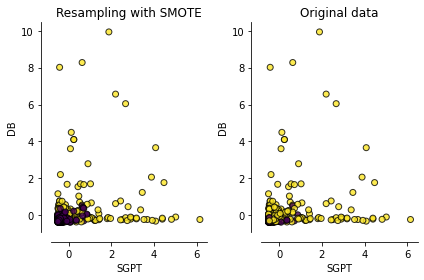

In [ ]:
plot_augmented_data(X_train, y_train, ['SGPT','DB'], feature_scaler, class_balancer)

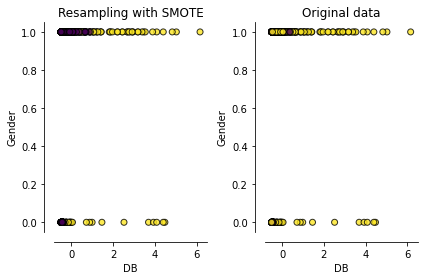

In [ ]:
plot_augmented_data(X_train, y_train, ['DB','Gender'], feature_scaler, class_balancer)

###3.3 Dimensionality reduction methods<a class="anchor" id="dim_reduction_methods"></a>

####3.3.1 Principal component analysis<a class="anchor" id="pca"></a>
PCA is one of the most popular unsupervised dimensionality reduction technique that allows to reduce the dimensionality of large datasets. Is an unsupervised method since it involves only a set of features $X_1, X_2,...,X_d$ and no associated response $Y$.

It consists in making an orthogonal projection of the data onto a lower dimensional space that:
- maximizes the variance of the projected data
- minimizes the mean squared distance between data points and projections

#### Maximum variance perspective
PCA aims to find a low-dimensional representation of the data that captures as much of the information as possible. Since the variance is an indicator of the spread of the data, is possible derive PCA as a dimensionality reduction algorithm that maximizes the variance in this lower-dimensional space.
Each dimension (or principal component) found by PCA is a linear combination of the d features.
The first principal component $Z_1$ is the normalized ($\sum_{j=1}^{d} \phi_{j1}^2 = 1 $) linear combination of the orginal set of features $X_1, X_2,...,X_d$:

$ Z_1 = \phi_{11} X_1 +  \phi_{21} X_2 + ... +  \phi_{d1} X_d $

that has the largest variance.

$\phi_{1} = (\phi_{11}, \phi_{21}, ..., \phi_{d1})^T$ is the loading vector of the principal component and defines the direction in the feature space along which the data vary the most.

Given an m x d dataset $X$, to find the first principal component loading vector we need to solve the following optimization problem:

$\underset{\phi_{11}, ..., \phi_{d1}}{maximize} \ \{ \frac{1}{m} \sum_{i=1}^m \ ( \sum_{j=1}^d \phi_{j1} x_{ij} )^2 \} \ subject \ to \ \sum_{j=1}^{d} \phi_{j1}^2 = 1$ 

After the first principal component $Z_1$ is determined, the second principal component $Z_2$ is computed as the linear combination of $X_1, X_2,...,X_d$ that has the maximal variance out of all linear combinations that are uncorrelated with $Z_1$. Note that, constraining $Z_2$ to be uncorrelated with $Z_1$ is equivalent to constraining the direction of $\phi_2$ to be orthogonal to the direction of $\phi_1$.
Then, each subsequent PC computed is orthogonal to the previous ones and points in the direction of the largest variance of the residual subspace.
#### Projection perspective
PCA can be derived as an algorithm that directly minimizes the average reconstruction error.
This perspective allows to interpret PCA as a linear auto-encoder.
In detail, we found a compressed version $z$ of original data $x$ and then the compressed data can be reconstructed into $\bar{x}$ which lives in the original dimensional space:

![image](pca_reconstructed_err.png)

The aim is to project (encoding) data onto a lower-dimensional space via an orthogonal linear mapping, while retaining as much information as possible, in such a way to minimize the distance between the original data and the reconstructed data (decoding). The mathematical optimization problem is the following:

$\underset{W \in R^{n,d}, \ U  \in R^{d,n}}{argmin} \ \ \frac{1}{m} \sum_{i=1}^m \ \lVert x_i - UW\bar{x_i}\rVert_2^2$  (Reconstruction error)

where $W \in 𝑅^{n,d}$ and $U \in 𝑅^{d,n}$ are the encoding and decoding matrices respectively.

Given a set of data points $x_1, ..., x_m \in R^d$ and let $A = X^T * X$, the solution to the problem is given by the setting:

$U = (u_1, ..., u_n)$ and $W = U^T$

where $u_1, ... u_n$ are the first orthonormal eigenvectors of $A$ corresponding to the first n largest eigenvalues ($\lambda_1\geq, ..., \geq\lambda_n$). The sum the remaining eigenvalues ($\lambda_{n+1}\geq, ..., \geq\lambda_d$) gives the reconstruction error.

In [ ]:
X_train_scaled = StandardScaler().fit_transform(X_train)
pca = PCA(n_components=len(features_names), random_state=config_dict['GENERAL']['SEED'])
X_train_pca_trasformed = pca.fit_transform(X_train_scaled)

In [ ]:
fig = prepare_PCA_explained_variance_plot(pca, template_)

if config_dict['GENERAL']['SHOW_METHOD'] == 0:
  fig.show()
elif config_dict['GENERAL']['SHOW_METHOD'] == 1:
  py.iplot(fig, filename = 'explaied_variance')
elif config_dict['GENERAL']['SHOW_METHOD'] == 2:
  fig.show(renderer='svg')

In [ ]:
num_components = 7

Loadings are visualized by arrows that are under an angle and have a certain length. The angle represents the contribution of a particular feature in the direction of the PCs where it contributes. The length of the arrow depicts the strength of the contribution of the feature in that direction.

In [ ]:
fig = prepare_biplot(pca, X_train_pca_trasformed, y_train, features_names, template_)

if config_dict['GENERAL']['SHOW_METHOD'] == 0:
  fig.show()
elif config_dict['GENERAL']['SHOW_METHOD'] == 1:
  py.iplot(fig, filename = 'bi_plot')
elif config_dict['GENERAL']['SHOW_METHOD'] == 2:
  fig.show(renderer='svg')

In [ ]:
loadings = pd.DataFrame(pca.components_.T[:, 0:2], columns=['PC1', 'PC2'], index=features_names)
loadings

,PC1,PC2
Age,0.112242,-0.298154
Gender,0.098340,-0.009278
TB,0.453956,0.204490
DB,0.444718,0.205593
AAP,0.230227,-0.011090
SGPT,0.293594,0.414125
SGOT,0.332129,0.396609
TP,-0.281027,0.389223
ALB,-0.397403,0.454556
AGR,-0.295743,0.374026


In [ ]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loading_matrix = pd.DataFrame(loadings[:, 0:2], columns=['PC1', 'PC2'], index=features_names)
loading_matrix

,PC1,PC2
Age,0.192074,-0.432884
Gender,0.168284,-0.013470
TB,0.776831,0.296896
DB,0.761022,0.298497
AAP,0.393975,-0.016101
SGPT,0.502412,0.601261
SGOT,0.568354,0.575830
TP,-0.480906,0.565105
ALB,-0.680054,0.659962
AGR,-0.506089,0.543042


####3.3.2 Empirical feature selection<a class="anchor" id="empirical_feature_selection"></a>

To reduce the dataset dimensionality is possible to apply an "empirical dimensionality reduction" technique which consists in removing duplicated features according to their pairwise correlation with others.

The strategy consists in performing an agglomerative hierarchical clustering with average linkage to cluster the features according to their correlation.
The process starts by creating one cluster for each feature and by computing the pairwise distance (=correlation) between all the clusters. Then, the two clusters with the highest average correlation are selected and merged. In the next iteration, the next pair of clusters with highest correlation is selected and merged. This step is repeated until we end up with one cluster. The dendogram helps to visualize the clusters.

In [ ]:
fig = prepare_dendogram(X_train, title_ = "Dendrogram of clustering the features according to correlation", template_=template_)
'''
if config_dict['GENERAL']['SHOW_METHOD'] == 0:
  fig.show()
elif config_dict['GENERAL']['SHOW_METHOD'] == 1:
  py.iplot(fig, filename = 'dendogram')
elif config_dict['GENERAL']['SHOW_METHOD'] == 2:
  fig.show(renderer='svg')'''
py.iplot(fig, filename = 'dendogram')

The dendogram shows 3 main clusters highlighted in brown, green and orange.
The feature pairs which are clustered with lower distance are TB and DB (brown cluster). Also SGPT and SGOT are quite close. The orange cluster which contains AGR, TP, ALB shows a correlation but not so strong.
The choice is to remove TB and SGOT features since they are considerated as duplicates.

In [ ]:
duplicated_features = ["SGOT", "TB"]
cols_without_duplicate = [x for x in features_names if x not in duplicated_features]
num_cols_without_duplicate = [x for x in cols_without_duplicate if x not in config_dict['GENERAL']['BOOLEAN_FEATURES']]
X_train_reduced = X_train[cols_without_duplicate]
X_test_reduced= X_test[cols_without_duplicate]

##Classification

###Metrics

###Cross validation

In [ ]:
config_dict['CLASSIFICATION']['MODELS'] = {
        'LinearSVC': svm.SVC(kernel='linear'),
        'RbfSVC': svm.SVC(kernel='rbf'),
        'KNN': neighbors.KNeighborsClassifier(),
        'LogisticRegression': linear_model.LogisticRegression(),
        'DecisionTree': tree.DecisionTreeClassifier(),
        'RandomForest': ensemble.RandomForestClassifier(),
}

config_dict['CLASSIFICATION']['GENERAL'] = {
    'score_metric': 'f1',
    'cv_inner': 5,
    'cv_outer': 10,
    'seed': config_dict['GENERAL']['SEED']
}

config_dict['CLASSIFICATION']['PARAMS'] = {
    'KNN': {
            'KNN__n_neighbors' : list(range(1,35, 4)), 
            'KNN__weights': ['uniform', 'distance' ],
            #'KNN__n_jobs' : [-1],
            },
    'LinearSVC': {
            'LinearSVC__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 
            #'LinearSVC__kernel': ['linear'],  
            },
    'RbfSVC': {
            'RbfSVC__C': [10, 100, 1000],  
            'RbfSVC__gamma': [0.001, 0.01, 0.1, 1],    
            #'RbfSVC__kernel': ['rbf'],
            },
    'LogisticRegression': {
            'LogisticRegression__penalty': ['l1', 'l2'],
            'LogisticRegression__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],   
            'LogisticRegression__max_iter': [1000],
            'LogisticRegression__solver': ['liblinear'],
            },
    'DecisionTree': {
            'DecisionTree__max_depth': list(range(2, 10)),
            'DecisionTree__min_samples_split': list(range(2, 10)),
            'DecisionTree__criterion' : ['gini', 'entropy'],
            },
    'RandomForest': {
            'RandomForest__n_estimators': [10, 100],
            'RandomForest__criterion' : ['gini', 'entropy'],
            'RandomForest__max_depth': list(range(2, 10)),
            'RandomForest__min_samples_split': [2, 5, 10], 
            'RandomForest__max_features': ['sqrt'],
            #'RandomForest__n_jobs' : [-1],
            },
}

show_dict(config_dict)

{'CLASSIFICATION': {'BALANCER': {'SMOTENC': SMOTENC(categorical_features=[9], random_state=42,
        sampling_strategy='not majority')},
                    'GENERAL': {'cv_inner': 5,
                                'cv_outer': 10,
                                'score_metric': 'f1',
                                'seed': 42},
                    'MODELS': {'DecisionTree': DecisionTreeClassifier(),
                               'KNN': KNeighborsClassifier(),
                               'LinearSVC': SVC(kernel='linear'),
                               'LogisticRegression': LogisticRegression(),
                               'RandomForest': RandomForestClassifier(),
                               'RbfSVC': SVC()},
                    'PARAMS': {'DecisionTree': {'DecisionTree__criterion': ['gini',
                                                                            'entropy'],
                                                'DecisionTree__max_depth': [2,
                  

In [ ]:
pd.DataFrame.from_dict(pd.DataFrame(config_dict['CLASSIFICATION']['PARAMS']['LinearSVC'], columns = ['LinearSVC__C'])).T

,0,1,2,3,4,5,6
LinearSVC__C,0.001,0.01,0.1,1.0,10.0,100.0,1000.0


In [ ]:
pd.DataFrame.from_dict(pd.DataFrame(config_dict['CLASSIFICATION']['PARAMS']['RbfSVC']['RbfSVC__C'], columns = ['RbfSVC__C'])).T

,0,1,2
RbfSVC__C,10,100,1000


In [ ]:
pd.DataFrame.from_dict(pd.DataFrame(config_dict['CLASSIFICATION']['PARAMS']['RbfSVC']['RbfSVC__gamma'], columns = ['RbfSVC__gamma'])).T

,0,1,2,3
RbfSVC__gamma,0.001,0.01,0.1,1.0


In [ ]:
'''feature_scaler = config_dict['CLASSIFICATION']['SCALER']['StandardScaler']
feature_scaler1 = clone(feature_scaler)
_ = feature_scaler1.fit_transform(X_train) # to retreive the categorical features indices (order of columns is modified by the scaler)

#set categorical features indices
class_balancer = config_dict['CLASSIFICATION']['BALANCER']['SMOTENC'].set_params(categorical_features=[i for i, f in enumerate(feature_scaler1.get_feature_names_out()) if f in config_dict['GENERAL']['BOOLEAN_FEATURES']])

num_components = 7'''

"feature_scaler = config_dict['CLASSIFICATION']['SCALER']['StandardScaler']\nfeature_scaler1 = clone(feature_scaler)\n_ = feature_scaler1.fit_transform(X_train) # to retreive the categorical features indices (order of columns is modified by the scaler)\n\n#set categorical features indices\nclass_balancer = config_dict['CLASSIFICATION']['BALANCER']['SMOTENC'].set_params(categorical_features=[i for i, f in enumerate(feature_scaler1.get_feature_names_out()) if f in config_dict['GENERAL']['BOOLEAN_FEATURES']])\n\nnum_components = 7"

In [ ]:
classifiers = []

###Support vector machines

Computing inner cross validation for grid search of best hyperparameters...
Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV 1/5] END ................LinearSVC__C=0.001;, score=0.261 total time=   0.0s
[CV 2/5] END ................LinearSVC__C=0.001;, score=0.356 total time=   0.0s
[CV 3/5] END ................LinearSVC__C=0.001;, score=0.182 total time=   0.0s
[CV 4/5] END ................LinearSVC__C=0.001;, score=0.232 total time=   0.0s
[CV 5/5] END ................LinearSVC__C=0.001;, score=0.185 total time=   0.0s
[CV 1/5] END .................LinearSVC__C=0.01;, score=0.637 total time=   0.0s
[CV 2/5] END .................LinearSVC__C=0.01;, score=0.575 total time=   0.0s
[CV 3/5] END .................LinearSVC__C=0.01;, score=0.421 total time=   0.0s
[CV 4/5] END .................LinearSVC__C=0.01;, score=0.488 total time=   0.0s
[CV 5/5] END .................LinearSVC__C=0.01;, score=0.506 total time=   0.0s
[CV 1/5] END ..................LinearSVC__C=0.1;, scor

,LinearSVC__C
0,1
1,100
2,10
3,10
4,1
5,1
6,10
7,1
8,1000
9,10


None
Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV 1/5] END ................LinearSVC__C=0.001;, score=0.164 total time=   0.0s
[CV 2/5] END ................LinearSVC__C=0.001;, score=0.341 total time=   0.1s
[CV 3/5] END ................LinearSVC__C=0.001;, score=0.237 total time=   0.1s
[CV 4/5] END ................LinearSVC__C=0.001;, score=0.350 total time=   0.1s
[CV 5/5] END ................LinearSVC__C=0.001;, score=0.414 total time=   0.1s
[CV 1/5] END .................LinearSVC__C=0.01;, score=0.477 total time=   0.1s
[CV 2/5] END .................LinearSVC__C=0.01;, score=0.606 total time=   0.1s
[CV 3/5] END .................LinearSVC__C=0.01;, score=0.442 total time=   0.1s
[CV 4/5] END .................LinearSVC__C=0.01;, score=0.542 total time=   0.0s
[CV 5/5] END .................LinearSVC__C=0.01;, score=0.627 total time=   0.1s
[CV 1/5] END ..................LinearSVC__C=0.1;, score=0.606 total time=   0.1s
[CV 2/5] END ..................LinearSVC__C=

,LinearSVC__C
0,1000


None

Test classification report
              precision    recall  f1-score   support

           0       0.46      0.91      0.61        34
           1       0.94      0.57      0.71        83

    accuracy                           0.67       117
   macro avg       0.70      0.74      0.66       117
weighted avg       0.80      0.67      0.68       117



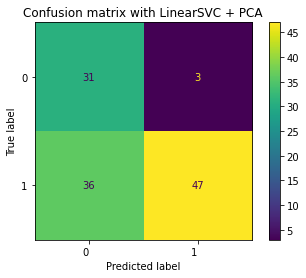

In [ ]:
linear_svm_classifier_pca = Classifier('LinearSVC', config_dict['CLASSIFICATION']['MODELS']['LinearSVC'], 
                              config_dict['CLASSIFICATION']['GENERAL'], 
                              config_dict['CLASSIFICATION']['PARAMS']['LinearSVC'], 
                              class_balancer, 
                              feature_scaler)
file_name = f'{linear_svm_classifier_pca.name}_PCA.pkl'

if config_dict['GENERAL']['PERFORM_NCV']:
  linear_svm_pca_mean_score, linear_svm_pca_std_score = linear_svm_classifier_pca.nested_cv(X_train, y_train, apply_PCA=True, num_components=num_components)
  save(linear_svm_classifier_pca, os.path.join(MODELS_DIRPATH, file_name))
else:
  linear_svm_classifier_pca = load(os.path.join(MODELS_DIRPATH, file_name))
  linear_svm_classifier_pca.print_nested_cv_results()

classifiers.append(linear_svm_classifier_pca)
linear_svm_classifier_pca.cv(X_train, X_test, y_train, y_test, apply_PCA=True, num_components=num_components)

{'C': 1000, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Fitting...
DONE


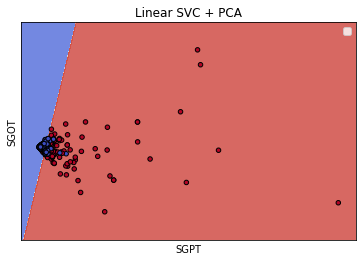

In [ ]:
params = linear_svm_classifier_pca.best_model.named_steps[linear_svm_classifier_pca.name].get_params()
print(params)

plot_2D_svm_decision_boundary(X_train, y_train, X_test, y_test, svm.SVC(**params), 
                              features_pair=['SGPT','SGOT'], title="Linear SVC + PCA", apply_PCA=True)


Computing inner cross validation for grid search of best hyperparameters...
Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV 1/5] END ................LinearSVC__C=0.001;, score=0.261 total time=   0.0s
[CV 2/5] END ................LinearSVC__C=0.001;, score=0.356 total time=   0.0s
[CV 3/5] END ................LinearSVC__C=0.001;, score=0.182 total time=   0.0s
[CV 4/5] END ................LinearSVC__C=0.001;, score=0.232 total time=   0.0s
[CV 5/5] END ................LinearSVC__C=0.001;, score=0.185 total time=   0.0s
[CV 1/5] END .................LinearSVC__C=0.01;, score=0.637 total time=   0.0s
[CV 2/5] END .................LinearSVC__C=0.01;, score=0.558 total time=   0.0s
[CV 3/5] END .................LinearSVC__C=0.01;, score=0.421 total time=   0.0s
[CV 4/5] END .................LinearSVC__C=0.01;, score=0.506 total time=   0.0s
[CV 5/5] END .................LinearSVC__C=0.01;, score=0.487 total time=   0.0s
[CV 1/5] END ..................LinearSVC__C=0.1;, scor

,LinearSVC__C
0,10
1,100
2,10
3,1
4,100
5,1
6,1
7,10
8,10
9,1


None
Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV 1/5] END ................LinearSVC__C=0.001;, score=0.164 total time=   0.0s
[CV 2/5] END ................LinearSVC__C=0.001;, score=0.341 total time=   0.0s
[CV 3/5] END ................LinearSVC__C=0.001;, score=0.237 total time=   0.0s
[CV 4/5] END ................LinearSVC__C=0.001;, score=0.350 total time=   0.0s
[CV 5/5] END ................LinearSVC__C=0.001;, score=0.414 total time=   0.0s
[CV 1/5] END .................LinearSVC__C=0.01;, score=0.460 total time=   0.0s
[CV 2/5] END .................LinearSVC__C=0.01;, score=0.606 total time=   0.0s
[CV 3/5] END .................LinearSVC__C=0.01;, score=0.442 total time=   0.0s
[CV 4/5] END .................LinearSVC__C=0.01;, score=0.542 total time=   0.0s
[CV 5/5] END .................LinearSVC__C=0.01;, score=0.627 total time=   0.0s
[CV 1/5] END ..................LinearSVC__C=0.1;, score=0.571 total time=   0.0s
[CV 2/5] END ..................LinearSVC__C=

,LinearSVC__C
0,1000


None

Test classification report
              precision    recall  f1-score   support

           0       0.47      0.91      0.62        34
           1       0.94      0.58      0.72        83

    accuracy                           0.68       117
   macro avg       0.71      0.75      0.67       117
weighted avg       0.80      0.68      0.69       117



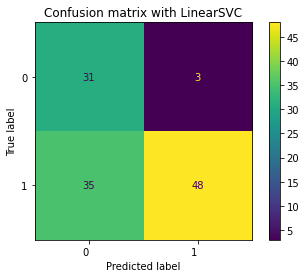

In [ ]:
linear_svm_classifier = Classifier('LinearSVC', config_dict['CLASSIFICATION']['MODELS']['LinearSVC'], 
                            config_dict['CLASSIFICATION']['GENERAL'], 
                            config_dict['CLASSIFICATION']['PARAMS']['LinearSVC'], 
                            class_balancer, 
                            feature_scaler)
file_name = f'{linear_svm_classifier.name}.pkl'

if config_dict['GENERAL']['PERFORM_NCV']:
  linear_svm_mean_score, linear_svm_std_score = linear_svm_classifier.nested_cv(X_train, y_train, apply_PCA=False)
  save(linear_svm_classifier, os.path.join(MODELS_DIRPATH, file_name))
else:
  linear_svm_classifier = load(os.path.join(MODELS_DIRPATH, file_name))
  linear_svm_classifier.print_nested_cv_results()

classifiers.append(linear_svm_classifier)
linear_svm_classifier.cv(X_train, X_test, y_train, y_test, apply_PCA=False)

{'C': 1000, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Fitting...
DONE


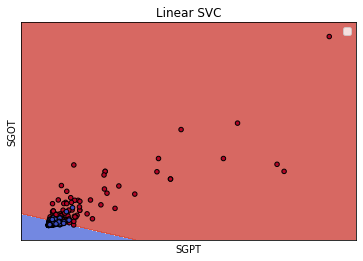

In [ ]:
params = linear_svm_classifier.best_model.named_steps[linear_svm_classifier.name].get_params()
print(params)

plot_2D_svm_decision_boundary(X_train, y_train, X_test, y_test, svm.SVC(**params), 
                              features_pair=['SGPT','SGOT'], title="Linear SVC", apply_PCA=False)


Computing inner cross validation for grid search of best hyperparameters...
Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV 1/5] END ................LinearSVC__C=0.001;, score=0.182 total time=   0.1s
[CV 2/5] END ................LinearSVC__C=0.001;, score=0.395 total time=   0.1s
[CV 3/5] END ................LinearSVC__C=0.001;, score=0.154 total time=   0.1s
[CV 4/5] END ................LinearSVC__C=0.001;, score=0.152 total time=   0.0s
[CV 5/5] END ................LinearSVC__C=0.001;, score=0.156 total time=   0.0s
[CV 1/5] END .................LinearSVC__C=0.01;, score=0.593 total time=   0.0s
[CV 2/5] END .................LinearSVC__C=0.01;, score=0.552 total time=   0.0s
[CV 3/5] END .................LinearSVC__C=0.01;, score=0.400 total time=   0.1s
[CV 4/5] END .................LinearSVC__C=0.01;, score=0.518 total time=   0.0s
[CV 5/5] END .................LinearSVC__C=0.01;, score=0.554 total time=   0.1s
[CV 1/5] END ..................LinearSVC__C=0.1;, scor

,LinearSVC__C
0,1
1,1
2,10
3,1
4,100
5,1
6,100
7,1
8,100
9,1000


None
Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV 1/5] END ................LinearSVC__C=0.001;, score=0.139 total time=   0.0s
[CV 2/5] END ................LinearSVC__C=0.001;, score=0.317 total time=   0.0s
[CV 3/5] END ................LinearSVC__C=0.001;, score=0.189 total time=   0.0s
[CV 4/5] END ................LinearSVC__C=0.001;, score=0.437 total time=   0.0s
[CV 5/5] END ................LinearSVC__C=0.001;, score=0.444 total time=   0.1s
[CV 1/5] END .................LinearSVC__C=0.01;, score=0.527 total time=   0.0s
[CV 2/5] END .................LinearSVC__C=0.01;, score=0.654 total time=   0.0s
[CV 3/5] END .................LinearSVC__C=0.01;, score=0.460 total time=   0.0s
[CV 4/5] END .................LinearSVC__C=0.01;, score=0.580 total time=   0.0s
[CV 5/5] END .................LinearSVC__C=0.01;, score=0.596 total time=   0.0s
[CV 1/5] END ..................LinearSVC__C=0.1;, score=0.586 total time=   0.0s
[CV 2/5] END ..................LinearSVC__C=

,LinearSVC__C
0,10


None

Test classification report
              precision    recall  f1-score   support

           0       0.47      1.00      0.64        34
           1       1.00      0.54      0.70        83

    accuracy                           0.68       117
   macro avg       0.74      0.77      0.67       117
weighted avg       0.85      0.68      0.69       117



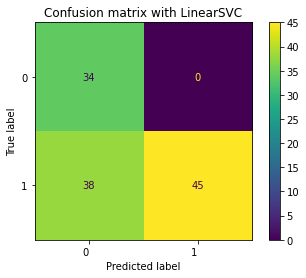

In [ ]:
feature_scaler_red = ColumnTransformer(
            remainder='passthrough',
            transformers=[
                ("standardscaler", StandardScaler(), num_cols_without_duplicate),
            ],
            verbose_feature_names_out=False)

feature_scaler1 = clone(feature_scaler_red)
_ = feature_scaler1.fit_transform(X_train_reduced) # to retreive the categorical features indices (order of columns is modified by the scaler)

#set categorical features indices
class_balancer_red = config_dict['CLASSIFICATION']['BALANCER']['SMOTENC'].set_params(categorical_features=[i for i, f in enumerate(feature_scaler1.get_feature_names_out()) if f in config_dict['GENERAL']['BOOLEAN_FEATURES']])

linear_svm_classifier_red = Classifier('LinearSVC', config_dict['CLASSIFICATION']['MODELS']['LinearSVC'], 
                            config_dict['CLASSIFICATION']['GENERAL'], 
                            config_dict['CLASSIFICATION']['PARAMS']['LinearSVC'], 
                            class_balancer_red, 
                            feature_scaler_red)
file_name = f'{linear_svm_classifier_red.name}.pkl'

if config_dict['GENERAL']['PERFORM_NCV']:
  linear_svm_red_mean_score, linear_svm_red_std_score = linear_svm_classifier_red.nested_cv(X_train_reduced, y_train, apply_PCA=False)
  save(linear_svm_classifier_red, os.path.join(MODELS_DIRPATH, file_name))
else:
  linear_svm_classifier_red = load(os.path.join(MODELS_DIRPATH, file_name))
  linear_svm_classifier_red.print_nested_cv_results()

classifiers.append(linear_svm_classifier_red)
linear_svm_classifier_red.cv(X_train_reduced, X_test_reduced, y_train, y_test, apply_PCA=False)

{'C': 10, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Fitting...
DONE


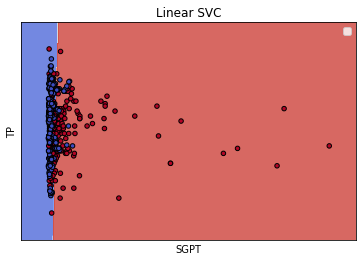

In [ ]:
params = linear_svm_classifier_red.best_model.named_steps[linear_svm_classifier_red.name].get_params()
print(params)

plot_2D_svm_decision_boundary(X_train_reduced, y_train, X_test_reduced, y_test, svm.SVC(**params), 
                              features_pair=['SGPT','TP'], title="Linear SVC", apply_PCA=False)


In [ ]:
rbf_svm_classifier = Classifier('RbfSVC', config_dict['CLASSIFICATION']['MODELS']['RbfSVC'], 
                            config_dict['CLASSIFICATION']['GENERAL'], 
                            config_dict['CLASSIFICATION']['PARAMS']['RbfSVC'], 
                            class_balancer, 
                            feature_scaler)

file_name = f'{rbf_svm_classifier.name}_PCA.pkl'

if config_dict['GENERAL']['PERFORM_NCV']:
  rbf_svm_mean_score, rbf_svm_std_score = rbf_svm_classifier.nested_cv(X_train, y_train, apply_PCA=True, num_components=num_components)
  save(rbf_svm_classifier, os.path.join(MODELS_DIRPATH, file_name))
else:
  rbf_svm_classifier = load(os.path.join(MODELS_DIRPATH, file_name))
  rbf_svm_classifier.print_nested_cv_results()

classifiers.append(rbf_svm_classifier)
rbf_svm_classifier.cv(X_train, X_test, y_train, y_test, apply_PCA=True)

In [ ]:
params = rbf_svm_classifier.best_model.named_steps[rbf_svm_classifier.name].get_params()
print(params)

plot_2D_svm_decision_boundary(X_train, y_train, X_test, y_test, svm.SVC(**params), 
                              features_pair=['SGPT','SGOT'], title="Rbf SVC", apply_PCA=True)

###KNN

In [ ]:
knn_classifier = Classifier('KNN', config_dict['CLASSIFICATION']['MODELS']['KNN'], 
                            config_dict['CLASSIFICATION']['GENERAL'], 
                            config_dict['CLASSIFICATION']['PARAMS']['KNN'], 
                            class_balancer, 
                            feature_scaler)
file_name = f'{knn_classifier.name}_PCA.pkl'

if  config_dict['GENERAL']['PERFORM_NCV']:
  knn_mean_score, knn_std_score = knn_classifier.nested_cv(X_train, y_train, apply_PCA=True, num_components=num_components)
  save(knn_classifier, os.path.join(MODELS_DIRPATH, file_name))
else:
  knn_classifier = load(os.path.join(MODELS_DIRPATH, file_name))
  knn_classifier.print_nested_cv_results()

classifiers.append(knn_classifier)
knn_classifier.cv(X_train, X_test, y_train, y_test, apply_PCA=True)

In [ ]:
params = knn_classifier.best_model.named_steps[knn_classifier.name].get_params()
print(params)

plot_2D_svm_decision_boundary(X_train, y_train, X_test, y_test, neighbors.KNeighborsClassifier(**params), 
                              features_pair=['SGPT','SGOT'], title="Rbf SVC", apply_PCA=False)

###Logistic Regression

In [ ]:
logistic_classifier = Classifier('LogisticRegression', config_dict['CLASSIFICATION']['MODELS']['LogisticRegression'], 
                            config_dict['CLASSIFICATION']['GENERAL'], 
                            config_dict['CLASSIFICATION']['PARAMS']['LogisticRegression'], 
                            class_balancer, 
                            feature_scaler)
file_name = f'{logistic_classifier.name}_PCA.pkl'

if config_dict['GENERAL']['PERFORM_NCV']:
  logistic_mean_score, logistic_std_score = logistic_classifier.nested_cv(X_train, y_train, apply_PCA=True, num_components=num_components)
  save(logistic_classifier, os.path.join(MODELS_DIRPATH, file_name))
else:
  logistic_classifier = load( os.path.join(MODELS_DIRPATH, file_name))
  logistic_classifier.print_nested_cv_results()

classifiers.append(logistic_classifier)
logistic_classifier.cv(X_train, X_test, y_train, y_test, apply_PCA=True)

In [ ]:
params = logistic_classifier.best_model.named_steps[logistic_classifier.name].get_params()
print(params)

plot_2D_svm_decision_boundary(X_train, y_train, X_test, y_test, linear_model.LogisticRegression(**params), 
                              features_pair=['SGPT','SGOT'], title="Rbf SVC", apply_PCA=False)

In [ ]:
plot_logistic_curve(logistic_classifier, "SGPT", X_test, y_test)

###Decision tree

In [ ]:
decision_tree_classifier = Classifier('DecisionTree', config_dict['CLASSIFICATION']['MODELS']['DecisionTree'], 
                            config_dict['CLASSIFICATION']['GENERAL'], 
                            config_dict['CLASSIFICATION']['PARAMS']['DecisionTree'], 
                            class_balancer, 
                            feature_scaler)
file_name = f'{decision_tree_classifier.name}.pkl'

if config_dict['GENERAL']['PERFORM_NCV']:
  decision_tree_mean_score, decision_tree_std_score = decision_tree_classifier.nested_cv(X_train, y_train, apply_PCA=False, num_components=num_components)
  save(decision_tree_classifier, os.path.join(MODELS_DIRPATH, file_name))
else:
  decision_tree_classifier = load(os.path.join(MODELS_DIRPATH, file_name))
  decision_tree_classifier.print_nested_cv_results()

classifiers.append(decision_tree_classifier)
decision_tree_classifier.cv(X_train, X_test, y_train, y_test, apply_PCA=False)

In [ ]:
params = decision_tree_classifier.best_model.named_steps[decision_tree_classifier.name].get_params()
print(params)

plot_2D_svm_decision_boundary(X_train, y_train, X_test, y_test, tree.DecisionTreeClassifier(**params), 
                              features_pair=['SGPT','SGOT'], title="Rbf SVC", apply_PCA=False)

In [ ]:
plot_decision_tree(decision_tree_classifier, features_names, config_dict['GENERAL']['TARGET_COLUMN_NAME'], max_depth=5) # max_depth=None to show full tree

###Random forest

In [ ]:
random_forest_classifier = Classifier('RandomForest', config_dict['CLASSIFICATION']['MODELS']['RandomForest'], 
                            config_dict['CLASSIFICATION']['GENERAL'], 
                            config_dict['CLASSIFICATION']['PARAMS']['RandomForest'], 
                            class_balancer, 
                            feature_scaler)
file_name = f'{random_forest_classifier.name}.pkl'

if config_dict['GENERAL']['PERFORM_NCV']:
  random_forest_score, random_forset_std_score = random_forest_classifier.nested_cv(X_train, y_train, apply_PCA=False, num_components=num_components)
  save(random_forest_classifier, os.path.join(MODELS_DIRPATH, file_name))
else:
  random_forest_classifier = load(os.path.join(MODELS_DIRPATH, file_name))
  random_forest_classifier.print_nested_cv_results()

classifiers.append(random_forest_classifier)
random_forest_classifier.cv(X_train, X_test, y_train, y_test, apply_PCA=False)

In [ ]:
params = random_forest_classifier.best_model.named_steps[random_forest_classifier.name].get_params()
print(params)

plot_2D_svm_decision_boundary(X_train, y_train, X_test, y_test, ensemble.RandomForestClassifier(**params), 
                              features_pair=['SGPT','SGOT'], title="Random forest", apply_PCA=False)

###Configure the final model

In [ ]:
best_classifiers = []
best_score = 0
y_preds = []
clf_names = []
for classifier in classifiers:      
  if classifier.ncv_global_mean_score > best_score:
      best_score = classifier.ncv_global_mean_score

for classifier in classifiers: 
  if classifier.ncv_global_mean_score == best_score:
    best_classifiers.append(classifier)
  y_preds.append(classifier.y_pred)
  clf_names.append(classifier.name)

for best_classifier in best_classifiers:
  if best_classifier.apply_PCA == True:        
    print(f'\nBEST CLASSIFIER: {best_classifier.name} (F1-score={best_classifier.ncv_global_mean_score}), PCA applied')
  else:
    print(f'\nBEST CLASSIFIER: {best_classifier.name} (F1-score={best_classifier.ncv_global_mean_score})')

In [ ]:
plot_PRC(clf_names, y_preds, y_test)

##Conclusions